In [1]:
"""
concurrency.py

This script demonstrates a rudimentary concurrent trading system using the TWS API.
It combines multiple data streams—account updates, position updates, market scanner subscription,
and real-time market data (tickPrice)—to decide when to enter or exit trades.

The system uses threading to ensure that the API's event loop runs concurrently with our main code.
Throughout the code, extensive comments are provided to explain the logic and how each component works.
The trading strategy used here is improved compared to a basic demo:
    - It monitors account cash and will disconnect if the TotalCashBalance falls below an amount.
    - It requests position updates to track current holdings, preventing unintended short positions.
    - It uses a market scanner to subscribe to the top MOST_ACTIVE stocks on major U.S. exchanges.
    - For each of the top five scanner results, it subscribes to market data.
    - In the tickPrice callback, it compares the new tick price to the previously stored price.
      • If the price rises more than a % AND no current position exists, it triggers a BUY order.
      • If the price falls more than a % AND a position is currently held, it triggers a SELL order.
    - The strategy uses a fixed order quantity (with a slight variation if adding to an existing position).
    - All these functions operate concurrently via the TWS API's event loop.
"""

from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.tag_value import TagValue
from ibapi.order import Order
from ibapi.contract import Contract
from ibapi.scanner import ScannerSubscription

import datetime
import time
import threading

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque

import logging
# Configure logging to output INFO-level messages on the console
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

from apscheduler.schedulers.background import BackgroundScheduler

In [2]:
class TradingSystem(EClient, EWrapper):
    """
    This class subscribes to IB account and portfolio updates.
    
    At the end of the first complete update cycle (signaled via accountDownloadEnd),
    the final StockMarketValue is saved as the shares_init_amount in self.shares_init_amount.
    
    Then, in every subsequent real-time update (in updateAccountValue) when the key
    is "StockMarketValue", the current value is compared against self.shares_init_amount. If the
    StockMarketValue drops by more than the allowed threshold, we disconnect.

    """
    
    def __init__(self, n_stocks_scanner, candle_seconds, max_perc_loss, req_snapshot):
        # Initialize the EClient with self as the wrapper.
        EClient.__init__(self, self)
        self.max_perc_loss = max_perc_loss  # For example, 0.05 means 5% loss threshold.

        # Account values.
        self.TotalCashBalance = {}          
        self.NetLiquidation = None
        self.StockMarketValue = None

        # Portfolio details.
        self.portfolio = {}
        self.curr_portfolio = None 
        self.position_ref = {}

        # For storing aggregated values per update cycle (not strictly needed for shares_init_amount check).
        self.total_owned = {}    # Overall account value (NetLiquidation)
        self.total_shares = {}   # StockMarketValue

        # Account time for each update cycle.
        self.account_time = None

        # The dedicated shares_init_amount variable (set once at the end of the first update cycle).
        self.shares_init_amount = None

        self.n_stocks_scanner = n_stocks_scanner
        self.candle_seconds = candle_seconds
        self.req_snapshot = req_snapshot

        # Scanner contracts retrieved
        self.ScannerResults = {}
        self.daily_history = []
        # For real-time processing: fixed-size deque (depending by the number of stocks scanned, the length of the candlesticks in second, and a multiplier eg 300)
        # maxlen set in order to have sufficient data to generate the trading indicators, before the deque gets reset
        self.ticks_history = deque(maxlen = self.n_stocks_scanner * self.candle_seconds * 300)

        self.next_id = 0

        


    def nextValidId(self, orderId: int):
        pass


    
    def nextId(self) -> int:
        self.next_id += 1
        return self.next_id


        
    def error(self, reqId: int, errorTime: int, errorCode: int, 
              errorString: str, advancedOrderReject=""):
        pass
        # print(f"Error - reqId:{reqId}, errorTime:{errorTime}, errorCode:{errorCode}, "
        #       f"errorString:{errorString}, OrderReject:{advancedOrderReject}")

    
    
    def updateAccountValue(self, key: str, val: str, currency: str, accountName: str):
        """
        Called repeatedly during the account update cycle.
        This callback simply stores the incoming values.
        Also, for "StockMarketValue" updates that come in after the shares_init_amount has been set,
        a real-time safety check is performed.
        """
        if key == "TotalCashBalance":
            self.TotalCashBalance[currency] = float(val)
        elif key == "NetLiquidation":
            self.NetLiquidation = float(val)
        elif key == "StockMarketValue":
            self.StockMarketValue = float(val)
            
        if (self.shares_init_amount is not None  # wait for the initial amount to be processed in the 'accountDownloadEnd' method 
        and self.portfolio != self.curr_portfolio): # to add the new portfolio value only if it has been updated
            self.total_owned[self.account_time] = self.NetLiquidation
            shares_curr_amount = round(sum(self.portfolio.values()),2)
            self.total_shares[self.account_time] = shares_curr_amount
            print('[EXEC "updateAccountValue"] TotalCashBalance:', self.TotalCashBalance)
            print('[EXEC "updateAccountValue"] Current Portfolio:', self.portfolio)
            print('[EXEC "updateAccountValue"] Total EUR owned amounts:', self.total_owned)
            print('[EXEC "updateAccountValue"] Total USD shares amounts:', self.total_shares)
            self.curr_portfolio = self.portfolio.copy()
    
            #safety check (disconnect if shares amount drops below a threshold)
            if shares_curr_amount < self.shares_init_amount * (1 - self.max_perc_loss):
                print(f"shares_curr_amount {shares_curr_amount:.2f} "
                      f"is lower than the shares_init_amount {self.shares_init_amount:.2f} "
                      f"(a drop of more than {self.max_perc_loss:.2f}%).")
                print("Disconnecting for safety!")
                self.disconnect()

    
                
    def updatePortfolio(self, contract: Contract, position: float, marketPrice: float,
                        marketValue: float, averageCost: float, unrealizedPNL: float,
                        realizedPNL: float, accountName: str):
        """
        Called for each portfolio update.
        We store the market value for each stock keyed by the contract symbol.
        """
        self.portfolio[contract.symbol] = marketValue

    
    
    def updateAccountTime(self, timeStamp: str):
        """
        Saves the account time for the current update cycle.
        """
        self.account_time = timeStamp

    
    
    def accountDownloadEnd(self, accountName: str):
        """
        Called when the entire batch of account (and portfolio) updates is finished.
        We perform our final processing here.
        """
        # Set the shares_init_amount (if set here, and not directly in the 'updateAccountValue' method, it stores the correct result)
        if self.shares_init_amount is None:
            self.shares_init_amount = self.StockMarketValue
            print('[EXEC "accountDownloadEnd"] shares_init_amount:', self.shares_init_amount)



    def position(self, account, contract: Contract, position, avgCost):
        """
        Callback: Receives updates for positions held.
        We record the current position for each symbol in our position_ref dictionary,
        ensuring that trading logic can check current holdings to avoid short positions.
        """
        self.position_ref[contract.symbol] = float(position)
        # print(f'[EXEC "position"] {contract.symbol}: Position = {position}, AvgCost = {avgCost}')
        next_id = self.nextId()
        self.ScannerResults[next_id] = {
                                        "ConId": contract.conId,
                                        "Symbol": contract.symbol,
                                        "SecType": contract.secType,
                                        "Exchange": contract.exchange,
                                        "Currency": contract.currency,
                                        # add any other properties you need...
                                        }        
        self.reqMktData(reqId = next_id, # to provide a different reqId for each contract
                       contract = contract, 
                       genericTickList = "", # A coma delimited list of generic tick types (?)
                       snapshot = self.req_snapshot, 
                       regulatorySnapshot = False, 
                       mktDataOptions = []) 



    def positionEnd(self):
        """This is called once all position data for a given request are
        received and functions as an end marker for the position() data."""
        pass

    

    def scannerParameters(self, xml: str):
        """Provides the xml-formatted parameters available to create a marketscanner """
        with open("scanner_parameters.xml", "w", encoding="utf-8") as file:
            file.write(xml)

        
    
    def scannerData(self, reqId, rank, contractDetails, distance, benchmark, projection, legsStr):
        """
        Callback: Receives results from a market scanner subscription.
        We limit our processing to the top 'n_stocks_scanner' results.
        We add the scanned contracts to the position_ref dictionaty with an initial value of 0.
        Later, when we receive an update about the actual holdings through the 'position' callback, the same dictionary entry is updated with the real position value. 
        This way, if we’re already holding some shares of that instrument, the actual position update will overwrite the 0 that the scanner set.
        """
        self.contractDetails = contractDetails
        if rank < self.n_stocks_scanner:
            next_id = self.nextId()
            self.ScannerResults[next_id] = {
                                            "ConId": contractDetails.contract.conId,
                                            "Symbol": contractDetails.contract.symbol,
                                            "SecType": contractDetails.contract.secType,
                                            "Exchange": contractDetails.contract.exchange,
                                            "Currency": contractDetails.contract.currency,
                                            # add any other properties you need...
                                            }
            self.position_ref[self.contractDetails.contract.symbol] = 0 # Initialize our position for this contract to zero (avoid short positions)       
            
            # Call this function to request market data. The market data will be returned by the Callbacks --> 'tickPrice' and 'tickSize'
            self.reqMktData(reqId = next_id, # to provide a different reqId for each contract
                           contract = self.contractDetails.contract, 
                           genericTickList = "", # A coma delimited list of generic tick types (?)
                           snapshot = self.req_snapshot, 
                           regulatorySnapshot = False, 
                           mktDataOptions = []) 
            print(f'[EXEC "scannerData"] Rank {rank}: {self.contractDetails.contract.symbol} on {self.contractDetails.contract.exchange}')


    
    def scannerDataEnd(self, reqId):
        """
        Callback: Indicates that the market scanner subscription has finished sending data.
        Here, we cancel the scanner subscription to avoid duplicate data, but we do not disconnect.
        """
        self.cancelScannerSubscription(reqId)

    

    def tickString(self, reqId, tickType, value):
        pass
        # if reqId == self.next_id: # just printing the ScannerResults dictionary at the last reqId callback
        #     # we print ScannerResults here, even if its update is linked also to the callbacks: tickSize and tickPrice
        #     print('[EXEC "tickString"] ScannerResults:', self.ScannerResults) 


    
    def tickSize(self, reqId, tickType, size):
        """
        Market data tick size callback. Handles all size-related ticks.
        It adds available size data to the ScannerResults.
        """
        if tickType == 0:  # Bid Size
            self.ScannerResults[reqId]["Bid_size"] = int(size)
            self.ScannerResults[reqId]["TS_Bid_size"] = datetime.datetime.now().isoformat()
        elif tickType == 3:  # Ask Size
            self.ScannerResults[reqId]["Ask_size"] = int(size)
            self.ScannerResults[reqId]["TS_Ask_size"] = datetime.datetime.now().isoformat()
        elif tickType == 5:  # Last Size
            self.ScannerResults[reqId]["Last_size"] = int(size)
            self.ScannerResults[reqId]["TS_Last_size"] = datetime.datetime.now().isoformat()
        elif tickType == 8:  # Trading Volume
            self.ScannerResults[reqId]["Volume"] = int(size)
            self.ScannerResults[reqId]["TS_Volume"] = datetime.datetime.now().isoformat()
        
        # Record the update (this unified log call will filter out duplicates).
        self.record_tick_update(reqId)


        
    def tickPrice(self, reqId, tickType, price, attrib):
        """
        Market data tick price callback. Handles price-related ticks.
        Updates ScannerResults with the following fields:
          - Bid Price (tick type 1)
          - Ask Price (tick type 2)
          - Last Price (tick type 4)
        """
        if tickType == 1:
            self.ScannerResults[reqId]["Bid_price"] = price
            self.ScannerResults[reqId]["TS_Bid_price"] = datetime.datetime.now().isoformat()
        elif tickType == 2:
            self.ScannerResults[reqId]["Ask_price"] = price
            self.ScannerResults[reqId]["TS_Ask_price"] = datetime.datetime.now().isoformat()
        elif tickType == 4:
            self.ScannerResults[reqId]["Last_price"] = price
            self.ScannerResults[reqId]["TS_Last_price"] = datetime.datetime.now().isoformat()
    
        # Record the update.
        self.record_tick_update(reqId)
        

    
    def record_tick_update(self, reqId):
        # Create a new snapshot from the current market data.
        new_snapshot = self.ScannerResults[reqId].copy()
        
        # Gather all timestamp values (from keys starting with "TS_")
        ts_values = []
        for key, value in new_snapshot.items():
            if key.startswith("TS_") and value is not None: 
                dt = datetime.datetime.fromisoformat(value) if isinstance(value, str) else value
                ts_values.append(dt)
        
        # Compute the maximum timestamp (i.e., the latest update time) and add it as a new field.
        latest_ts = max(ts_values)
        # Store the consolidated timestamp in ISO format.
        new_snapshot["TimeStamp"] = latest_ts.isoformat()
    
        # Remove all individual timestamp keys from the snapshot.
        for key in list(new_snapshot.keys()):
            if key.startswith("TS_"):
                del new_snapshot[key]
        
        # Define the keys to check for duplication.
        # Exclude the 'TimeStamp' field since it is updated every time.
        keys_to_check = [k for k in new_snapshot if k != "TimeStamp"]
        
        # If ticks_history is not empty, compare with the last snapshot.
        if self.ticks_history:
            last_snapshot = self.ticks_history[-1]
            # Compare each significant key between the new snapshot and the last snapshot.
            if all(new_snapshot.get(k) == last_snapshot.get(k) for k in keys_to_check):
                # If all values (ignoring TimeStamp) are the same, consider it a duplicate.
                return  # Do not log this update.
        
        # Otherwise, log the new snapshot.
        self.ticks_history.append(new_snapshot)
        self.daily_history.append(new_snapshot)



    def tickSnapshotEnd(self, reqId):
        """
        When requesting market data snapshots, this market will indicate the
        snapshot reception is finished.
        """
        if reqId == self.next_id: # just printing the ScannerResults dictionary at the last tickSnapshotEnd callback
            print('[EXEC "tickSnapshotEnd"] ScannerResults:', self.ScannerResults)

        

    def archive_daily_data(self, folder="daily_archives"):
        """
        Archives the daily_history list to a CSV file. The file is named using the previous day's date.
        Intended to be called at 5:00 AM.
        """
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        previous_day = datetime.datetime.now() - datetime.timedelta(days=1)
        date_str = previous_day.strftime("%Y-%m-%d")
        filename = os.path.join(folder, f"daily_trading_data_{date_str}.csv")
        
        if self.daily_history:
            df_daily = pd.DataFrame(self.daily_history)
            df_daily.to_csv(filename, index=False)
            print(f"Archived daily data to {filename}.")
            self.daily_history = [] # reset the list for the next day data
        else:
            print("No data to archive for the previous day.")


    
    def start_scheduler(self, folder="daily_archives"):
        """
        Start the background scheduler to run archive_daily_data daily at 5:00 AM.
        """
        self.scheduler = BackgroundScheduler()
        # Schedule the archive job for 5 AM daily. archive_daily_data receives 'folder' as an argument.
        self.scheduler.add_job(self.archive_daily_data, 'cron', hour=5, minute=0, args=[folder])
        self.scheduler.start()
        print("Scheduler started: archive_daily_data will run at 5:00 AM daily.")




    # # Create a new market order object
    # order = Order()
    # order.tif = "DAY"           # Time in Force: Order is valid for the day
    # order.orderType = "MKT"     # Market Order
    # # Strategy Improvement:
    # # If we are not holding any position for this symbol, set an initial order quantity.
    # # If we already have a position, we may choose to add or reduce the holding.
    # initial_qty = 1  # Default order quantity

    # # Improved Logic:
    # # Check if the new price is significantly higher than the previous price (more than 5% gain).
    # if self.last_price > previous_price * 1.05:
    #     # Only consider buying if we are not already in a position or choose to scale in.
    #     if position_ref.get(contract.symbol, 0) == 0:
    #         order.action = "BUY"
    #         order.totalQuantity = initial_qty
    #         print(f"[Signal BUY] {contract.symbol}: Price increased from {previous_price:.2f} to {self.last_price:.2f}. No current position; buying {order.totalQuantity} shares.")
    #         self.placeOrder(self.nextId(), contract, order)
    #     else:
    #         # Optionally, add to an existing position if desired. Here, we add a smaller quantity.
    #         order.action = "BUY"
    #         order.totalQuantity = 3
    #         print(f"[Signal BUY Add] {contract.symbol}: Price increased from {previous_price:.2f} to {self.last_price:.2f}. Already holding {position_ref[contract.symbol]} shares; adding {order.totalQuantity} shares.")
    #         self.placeOrder(self.nextId(), contract, order)
    
    # # Check if the new price is significantly lower than the previous price (more than 6% drop)
    # elif self.last_price < previous_price * 0.94:
    #     # Only sell if we have a current long position; avoid going short.
    #     if position_ref.get(contract.symbol, 0) >= initial_qty:
    #         order.action = "SELL"
    #         # Sell a fixed quantity (could be full position if desired)
    #         order.totalQuantity = initial_qty
    #         print(f"[Signal SELL] {contract.symbol}: Price dropped from {previous_price:.2f} to {self.last_price:.2f}. Holding {position_ref[contract.symbol]} shares; selling {order.totalQuantity} shares.")
    #         self.placeOrder(self.nextId(), contract, order)
    #     else:
    #         print(f"[No SELL] {contract.symbol}: Price dropped from {previous_price:.2f} to {self.last_price:.2f} but insufficient position to sell.")
    
    # # Update the stored LAST price for future comparisons.
    # self.ScannerResults[reqId]["LAST"] = self.last_price



    # def openOrder(self, orderId, contract: Contract, order, orderState):
    #     """
    #     Callback: Informs us about the status of open orders.
    #     Here, we log any rejected orders with a timestamp for review.
    #     """
    #     if orderState.status == "Rejected":
    #         print(f"[Order Rejected] {datetime.datetime.now()} ID:{orderId} || {order.action} {order.totalQuantity} {contract.symbol}")

    # def execDetails(self, reqId, contract: Contract, execution):
    #     """
    #     Callback: Returns execution details upon order fills.
    #     This example prints a simple summary of the trade execution.
    #     """
    #     print(f"[Execution] Order ID:{execution.orderId} || {execution.side} {execution.shares} {contract.symbol} @ {execution.time}")




In [3]:
port = 7496  # Typical port for connecting to TWS (7496 for IB Gateway live trading)
clientId = 101

n_stocks_scanner = 7 # top n stocks to retrieve by the scanner
candle_seconds = 60 # number of seconds for the trading candlesticks aggregation
max_perc_loss = 5 # max percentage loss allowed (automatically disconnected if exceeded)
req_snapshot = False

# Create an instance of the TradingSystem and connect to TWS.
trading_system = TradingSystem(n_stocks_scanner, candle_seconds, max_perc_loss, req_snapshot)
trading_system .connect("localhost", port, clientId) # "localhost" == "127.0.0.1"

# Start the API processing loop in a separate thread so that it does not block the main thread.
#by setting daemon=True, we ensure that the event loop thread running trading_system .run() will not hold up the termination of the overall program. 
# because in TWS API integration, we want the main thread to handle shutdown logic gracefully without waiting for every background thread to finish.
threading.Thread(target=trading_system.run, daemon=True).start()

# Start the scheduler to trigger archive_daily_data at 5 AM.
trading_system.start_scheduler(folder="daily_archives")


2025-05-16 17:08:32,701 [INFO] sent startApi
2025-05-16 17:08:32,704 [INFO] REQUEST startApi {}
2025-05-16 17:08:32,706 [INFO] SENDING startApi b'\x00\x00\x00\x0b\x00\x00\x00G2\x00101\x00\x00'
2025-05-16 17:08:32,707 [INFO] ANSWER connectAck {}
2025-05-16 17:08:32,709 [INFO] ANSWER openOrderEnd {}
2025-05-16 17:08:32,725 [INFO] Adding job tentatively -- it will be properly scheduled when the scheduler starts
2025-05-16 17:08:32,727 [INFO] Added job "TradingSystem.archive_daily_data" to job store "default"
2025-05-16 17:08:32,728 [INFO] Scheduler started


Scheduler started: archive_daily_data will run at 5:00 AM daily.


In [4]:
account_check = False
parameters_check = False
scanner_check = True
portfolio_check = False

# Set up a market scanner subscription to identify trending opportunities.
sub = ScannerSubscription()
sub.instrument = "STK"             # We are interested in stocks.
sub.locationCode = "STK.US.MAJOR"    # Focus on major US exchanges (NYSE, NASDAQ, AMEX, etc.).
sub.scanCode = "MOST_ACTIVE"         # Use the "MOST_ACTIVE" scan to get highly traded stocks.

scan_options = [] # For internal use only, so we leave the list empty.

# Define filter options to narrow down the scanner results:
filter_options = [
    TagValue("avgVolumeAbove", "1000000"),  # Stocks with an average trading volume above 1,000,000
    TagValue("priceAbove", "50"),            
    TagValue("priceBelow", "2000")          
]

In [5]:
if account_check:
    '''
    Request account updates to maintain a continuous stream of account cash data.
    We use this to check if the TotalCashBalance in our "BASE" currency (e.g., USD) remains sufficient.
    Callbacks --> 'updateAccountValue', 'updatePortfolio' and 'updateAccountTime'
    Set the parameter 'subscribe' to true to start the subscription and to false to stop it.
     
    The unrealized P&L information shown in the TWS Account Window which is sent to updatePortfolioValue will update either 
    (1) when a trade for that particular instrument occurs or 
    (2) every 3 minutes. 
    The realized P&L data in the TWS Account Window is reset to 0 once per day.
    '''
    
    trading_system.reqAccountUpdates(subscribe=True, # "True": the client will start receiving account and Portfolio updates, "False": it stops doing it
                          acctCode="") # The account code for which to receive account and portfolio updates

if parameters_check:
    """
    Requests an XML string that describes all possible scanner queries.
    A string containing all available XML-formatted parameters will then be returned via EWrapper.scannerParameters,
    which can be used as parameters in the "reqScannerSubscription"
    Callback --> scannerParameters (saves the file "scanner_parameters.xml")
    """
    trading_system.reqScannerParameters()


if scanner_check:
    '''
    Request the market scanner subscription using a unique request ID.
    Note: The program will continue to run with ongoing account updates, position updates, market scanner data, and tick price processing concurrently,
    until the callback cancelScannerSubscription(self, reqId: int) is invoked
    Callbacks --> 'scannerData', 'scannerDataEnd'
    '''
    trading_system.reqScannerSubscription(reqId=0, # any unique id
                               subscription=sub,
                               scannerSubscriptionOptions=scan_options,
                               scannerSubscriptionFilterOptions=filter_options)

if portfolio_check:
    '''
    Request position updates so that position_ref is kept up to date with our current portfolio holdings.
    Requests real-time position data for all accounts.
    Callbacks --> 'position', 'positionEnd'
    '''
    trading_system.reqPositions()


2025-05-16 17:08:32,775 [INFO] REQUEST reqScannerSubscription {'reqId': 0, 'subscription': 2812209183088: Instrument: STK, LocationCode: STK.US.MAJOR, ScanCode: MOST_ACTIVE, 'scannerSubscriptionOptions': [], 'scannerSubscriptionFilterOptions': [2812209178720: avgVolumeAbove=1000000;, 2812209183520: priceAbove=50;, 2812209180208: priceBelow=2000;]}
2025-05-16 17:08:32,776 [INFO] SENDING reqScannerSubscription b'\x00\x00\x00o\x00\x00\x00\x160\x00-1\x00STK\x00STK.US.MAJOR\x00MOST_ACTIVE\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x00\x00\x00\x00avgVolumeAbove=1000000;priceAbove=50;priceBelow=2000;\x00\x00'


In [6]:
time.sleep(n_stocks_scanner)

2025-05-16 17:08:32,850 [INFO] ANSWER managedAccounts {'accountsList': 'U18112846'}
2025-05-16 17:08:33,549 [INFO] REQUEST reqMktData {'reqId': 1, 'contract': 2811778441920: ConId: 4815747, Symbol: NVDA, SecType: STK, LastTradeDateOrContractMonth: , Strike: 0, Right: , Multiplier: , Exchange: SMART, PrimaryExchange: , Currency: USD, LocalSymbol: NVDA, TradingClass: NMS, IncludeExpired: False, SecIdType: , SecId: , Description: , IssuerId: Combo:, 'genericTickList': '', 'snapshot': False, 'regulatorySnapshot': False, 'mktDataOptions': []}
2025-05-16 17:08:33,551 [INFO] SENDING reqMktData b'\x00\x00\x00=\x00\x00\x00\x0111\x001\x004815747\x00NVDA\x00STK\x00\x000.0\x00\x00\x00SMART\x00\x00USD\x00NVDA\x00NMS\x000\x00\x000\x000\x00\x00'
2025-05-16 17:08:33,554 [INFO] REQUEST reqMktData {'reqId': 2, 'contract': 2811778441632: ConId: 76792991, Symbol: TSLA, SecType: STK, LastTradeDateOrContractMonth: , Strike: 0, Right: , Multiplier: , Exchange: SMART, PrimaryExchange: , Currency: USD, LocalSy

[EXEC "scannerData"] Rank 0: NVDA on SMART
[EXEC "scannerData"] Rank 1: TSLA on SMART
[EXEC "scannerData"] Rank 2: TQQQ on SMART
[EXEC "scannerData"] Rank 3: PLTR on SMART
[EXEC "scannerData"] Rank 4: HIMS on SMART
[EXEC "scannerData"] Rank 5: SPY on SMART
[EXEC "scannerData"] Rank 6: UNH on SMART


2025-05-16 17:08:33,735 [INFO] ANSWER tickReqParams {'tickerId': 4, 'minTick': 0.01, 'bboExchange': '9c0001', 'snapshotPermissions': 3}
2025-05-16 17:08:33,736 [INFO] ANSWER tickGeneric {'reqId': 1, 'tickType': 49, 'value': 0.0}
2025-05-16 17:08:33,738 [INFO] ANSWER tickGeneric {'reqId': 3, 'tickType': 49, 'value': 0.0}
2025-05-16 17:08:33,740 [INFO] ANSWER tickGeneric {'reqId': 3, 'tickType': 49, 'value': 0.0}
2025-05-16 17:08:33,741 [INFO] ANSWER tickGeneric {'reqId': 3, 'tickType': 49, 'value': 0.0}
2025-05-16 17:08:33,744 [INFO] ANSWER tickGeneric {'reqId': 3, 'tickType': 49, 'value': 0.0}
2025-05-16 17:08:33,902 [INFO] ANSWER marketDataType {'reqId': 5, 'marketDataType': 1}
2025-05-16 17:08:33,905 [INFO] ANSWER tickReqParams {'tickerId': 5, 'minTick': 0.01, 'bboExchange': 'a60001', 'snapshotPermissions': 3}
2025-05-16 17:08:33,910 [INFO] ANSWER marketDataType {'reqId': 7, 'marketDataType': 1}
2025-05-16 17:08:33,912 [INFO] ANSWER tickReqParams {'tickerId': 7, 'minTick': 0.01, 'bbo

In [55]:
# --- Create the DataFrame from the ticks_history deque ---
df_ticks = pd.DataFrame.from_records(list(trading_system.ticks_history)).dropna()

# Convert the TimeStamp column from string to datetime.
df_ticks["TimeStamp"] = pd.to_datetime(df_ticks["TimeStamp"])

# Optionally, print out some DataFrame info.
print(df_ticks.info(), "\n")
print("Number of unique rows in df_ticks:", df_ticks.drop_duplicates().shape[0], "\n")
print(df_ticks.nunique(), "\n")

# Set the TimeStamp as the index (required for resampling).
df_ticks.set_index("TimeStamp", inplace=True)

# Define the frequency string for resampling (e.g. "5s" for 5-second candles).
freq = f"{trading_system.candle_seconds}s"  # trading_system.candle_seconds is the candle interval in seconds.

# --- Group by Symbol and Resample ---
ohlc_by_symbol = {}

# A helper function to aggregate volume.
# being "Volume" a cumulative (running) total for the day, we cannot simply sum the values over the candle period
# we need to compute the difference between the last and first volume values in each resampled interval
def volume_diff(x):
    # If there's only one record in the bucket, the traded volume is 0.
    if len(x) < 2:
        return 0
    return x.iloc[-1] - x.iloc[0]

for symbol, group in df_ticks.groupby("Symbol"):
    # Resample the 'Last_price' per symbol to compute OHLC candles for the defined interval.
    ohlc = group["Last_price"].resample(freq).ohlc()
    
    # Use the custom aggregation for cumulative volume:
    # Calculate the difference between the last and first tick of each candle.
    if "Volume" in group.columns:
        ohlc["volume"] = group["Volume"].resample(freq).agg(volume_diff)
    
    # Optionally, add the Symbol as a column for easier identification.
    ohlc["symbol"] = symbol
    
    # Store the resulting DataFrame in the dictionary.
    ohlc_by_symbol[symbol] = ohlc

# --- Example: Display the first few rows of the OHLC data for each Symbol ---
for symbol, ohlc_df in ohlc_by_symbol.items():
    print(ohlc_df.shape)
    print(ohlc_df)

df_ticks

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ConId       42000 non-null  int64         
 1   Symbol      42000 non-null  object        
 2   SecType     42000 non-null  object        
 3   Exchange    42000 non-null  object        
 4   Currency    42000 non-null  object        
 5   Last_price  42000 non-null  float64       
 6   Last_size   42000 non-null  int64         
 7   Volume      42000 non-null  int64         
 8   Bid_price   42000 non-null  float64       
 9   Bid_size    42000 non-null  int64         
 10  Ask_price   42000 non-null  float64       
 11  Ask_size    42000 non-null  int64         
 12  TimeStamp   42000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 4.2+ MB
None 

Number of unique rows in df_ticks: 42000 

ConId            6
Symbol           6
Se

,ConId,Symbol,SecType,Exchange,Currency,Last_price,Last_size,Volume,Bid_price,Bid_size,Ask_price,Ask_size
TimeStamp,,,,,,,,,,,,
2025-05-16 17:40:46.151972,13272,UNH,STK,SMART,USD,275.50,400,233440,275.40,400,275.55,100
2025-05-16 17:40:46.151972,13272,UNH,STK,SMART,USD,275.50,400,233444,275.40,400,275.55,100
2025-05-16 17:40:46.152978,4815747,NVDA,STK,SMART,USD,134.99,100,956088,134.98,1700,134.99,200
2025-05-16 17:40:46.152978,4815747,NVDA,STK,SMART,USD,134.99,100,956089,134.98,1700,134.99,200
2025-05-16 17:40:46.152978,76792991,TSLA,STK,SMART,USD,348.58,100,492706,348.55,300,348.63,200
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-16 17:52:48.922263,76792991,TSLA,STK,SMART,USD,347.77,100,517928,347.70,500,347.77,100
2025-05-16 17:52:48.922263,444857009,PLTR,STK,SMART,USD,128.32,100,310273,128.29,400,128.31,100
2025-05-16 17:52:48.922263,444857009,PLTR,STK,SMART,USD,128.32,100,310273,128.29,400,128.31,1000


In [56]:
# Create the DataFrame from the daily list (to create the daily history csv)

df_daily = pd.DataFrame.from_records(trading_system.daily_history).dropna()

df_daily["TimeStamp"] = pd.to_datetime(df_daily["TimeStamp"])

print(df_daily.info(), '\n')

print('Number of unique rows:\n', df_daily.drop_duplicates().shape[0], '\n')
print(df_daily.nunique(), '\n')

df_daily


<class 'pandas.core.frame.DataFrame'>
Index: 159281 entries, 6 to 159318
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ConId       159281 non-null  int64         
 1   Symbol      159281 non-null  object        
 2   SecType     159281 non-null  object        
 3   Exchange    159281 non-null  object        
 4   Currency    159281 non-null  object        
 5   Bid_price   159281 non-null  float64       
 6   TimeStamp   159281 non-null  datetime64[ns]
 7   Bid_size    159281 non-null  float64       
 8   Ask_price   159281 non-null  float64       
 9   Ask_size    159281 non-null  float64       
 10  Last_price  159281 non-null  float64       
 11  Last_size   159281 non-null  float64       
 12  Volume      159281 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(4)
memory usage: 17.0+ MB
None 

Number of unique rows:
 159281 

ConId             6
Symbol           

,ConId,Symbol,SecType,Exchange,Currency,Bid_price,TimeStamp,Bid_size,Ask_price,Ask_size,Last_price,Last_size,Volume
6,4815747,NVDA,STK,SMART,USD,134.65,2025-05-16 17:08:33.595190,1000.0,134.66,1000.0,134.65,500.0,845683.0
13,76792991,TSLA,STK,SMART,USD,347.13,2025-05-16 17:08:33.601699,300.0,347.27,100.0,347.20,100.0,424578.0
20,72539702,TQQQ,STK,SMART,USD,70.36,2025-05-16 17:08:33.612943,4700.0,70.37,5500.0,70.36,200.0,279781.0
21,76792991,TSLA,STK,SMART,USD,347.13,2025-05-16 17:08:33.616937,300.0,347.27,100.0,347.20,100.0,424587.0
22,4815747,NVDA,STK,SMART,USD,134.65,2025-05-16 17:08:33.619670,1000.0,134.66,1000.0,134.65,400.0,845683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159314,444857009,PLTR,STK,SMART,USD,128.34,2025-05-16 17:52:49.973271,200.0,128.33,400.0,128.34,100.0,310277.0
159315,444857009,PLTR,STK,SMART,USD,128.34,2025-05-16 17:52:49.973271,700.0,128.33,400.0,128.34,100.0,310277.0
159316,444857009,PLTR,STK,SMART,USD,128.34,2025-05-16 17:52:49.973832,700.0,128.36,400.0,128.34,100.0,310277.0
159317,444857009,PLTR,STK,SMART,USD,128.34,2025-05-16 17:52:49.973832,700.0,128.36,900.0,128.34,100.0,310277.0


In [57]:
def ts_rate(ts_series):
    # Compute the duration in seconds between the max and min timestamps
    duration = (ts_series.max() - ts_series.min()).total_seconds()
    if duration == 0:
        # If duration is zero, return 0 or you can choose to return float('nan')
        return 0  
    return ts_series.nunique() / duration

# Group by 'Symbol' and compute the rate for the TS_Last_price column
rates = df_daily.groupby('Symbol')['TimeStamp'].apply(ts_rate).reset_index(name='TimeStamps_per_sec')

print("Number of TimeStamps entries per second per Symbol:")
rates

Number of TimeStamps entries per second per Symbol:


,Symbol,TimeStamps_per_sec
0,HIMS,3.474333
1,NVDA,6.019477
2,PLTR,4.610674
3,TQQQ,4.399629
4,TSLA,5.816203
5,UNH,2.953179


In [58]:
def last_price_rate(group):
    # Ensure the group is sorted by TimeStamp
    group = group.sort_values('TimeStamp')
    
    # Create a boolean Series that is True when the price changes compared to the previous row
    # Note: The first row is automatically flagged, so subtract one if that isn’t desired.
    changes = group['Last_price'].ne(group['Last_price'].shift())
    change_count = changes.sum() 

    # Calculate how much time (in seconds) this group spans
    duration = (group['TimeStamp'].max() - group['TimeStamp'].min()).total_seconds()
    return change_count / duration

# Compute the rate per ticker by grouping by 'Symbol'
rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')

print("Average number of Last Price changes per second per Symbol:")
rates


Average number of Last Price changes per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_11464\1489499678.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')


,Symbol,LastPriceRate
0,HIMS,1.206680
1,NVDA,1.548726
2,PLTR,1.198692
3,TQQQ,0.780768
4,TSLA,2.481580
5,UNH,1.137141


In [59]:
# count, mean, standard deviation, minimum, and maximum for Last_price.
stats_last = df_daily.groupby('Symbol').agg(
    count_last_price=('Last_price', 'count'),
    mean_last_price=('Last_price', 'mean'),
    std_last_price=('Last_price', 'std'),
    min_last_price=('Last_price', 'min'),
    max_last_price=('Last_price', 'max')
)
print("Last Price Statistics by Symbol:")
stats_last

Last Price Statistics by Symbol:


,count_last_price,mean_last_price,std_last_price,min_last_price,max_last_price
Symbol,,,,,
HIMS,19742,60.656188,0.420745,59.59,61.49
NVDA,34959,134.927867,0.186838,134.48,135.33
PLTR,28103,128.273981,0.351301,127.45,128.79
TQQQ,26748,70.508318,0.165988,70.20,70.85
TSLA,34356,347.761172,0.848859,345.31,349.28
UNH,15373,275.857718,0.732663,273.86,277.08


In [60]:
# count, mean, standard deviation, minimum, and maximum for Volume.
stats_volume = df_daily.groupby('Symbol').agg(
    count_volume=('Volume', 'count'),
    mean_volume=('Volume', 'mean'),
    std_volume=('Volume', 'std'),
    min_volume=('Volume', 'min'),
    max_volume=('Volume', 'max')
)
print("\nVolume Statistics by Symbol:")
stats_volume


Volume Statistics by Symbol:


,count_volume,mean_volume,std_volume,min_volume,max_volume
Symbol,,,,,
HIMS,19742,266382.418397,18668.431831,232144.0,297474.0
NVDA,34959,923226.568266,42386.281899,845683.0,998088.0
PLTR,28103,287750.679821,13624.682809,264000.0,310277.0
TQQQ,26748,306406.545760,16195.927128,279781.0,334989.0
TSLA,34356,471887.957475,26986.752980,424578.0,517954.0
UNH,15373,227955.219216,9837.612543,211302.0,245978.0


In [61]:
# Get all unique symbols.
symbols = df_daily['Symbol'].unique()

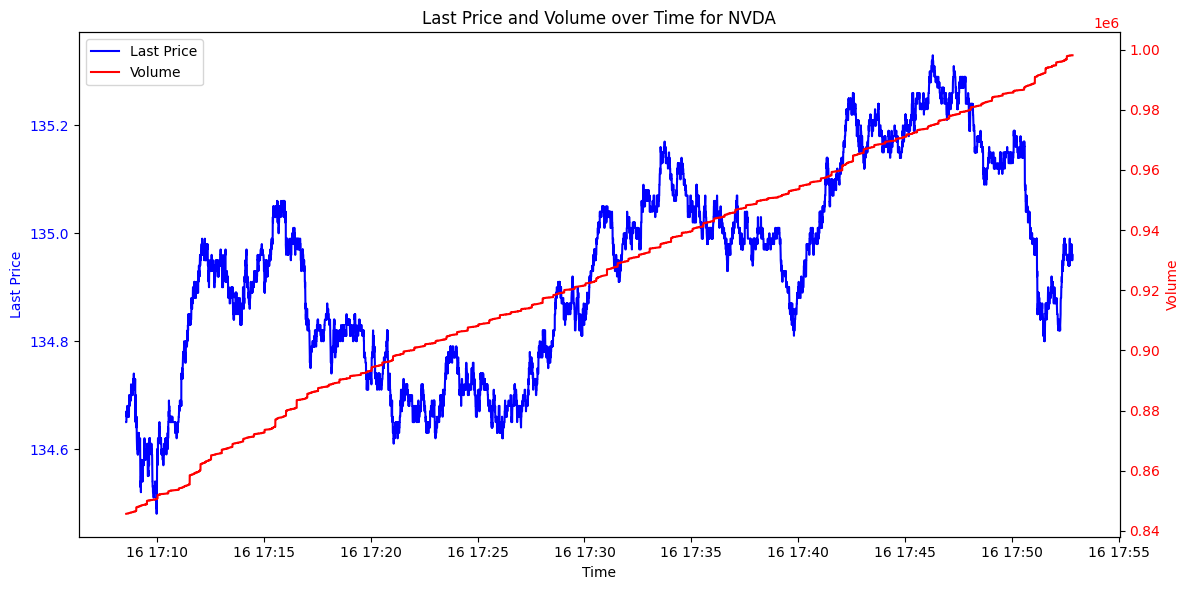

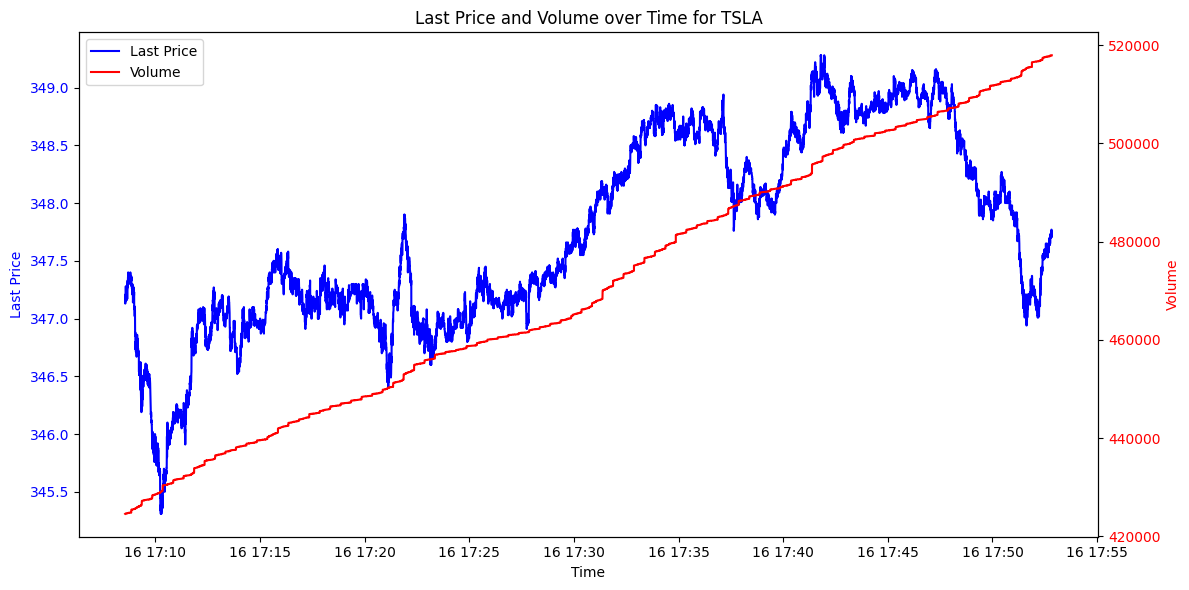

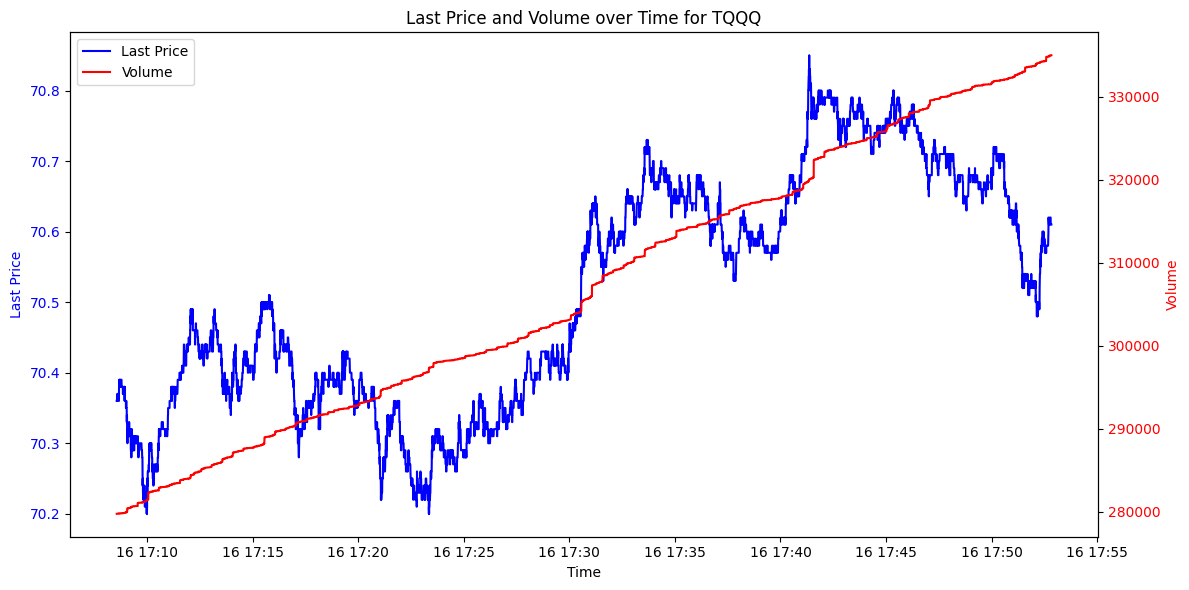

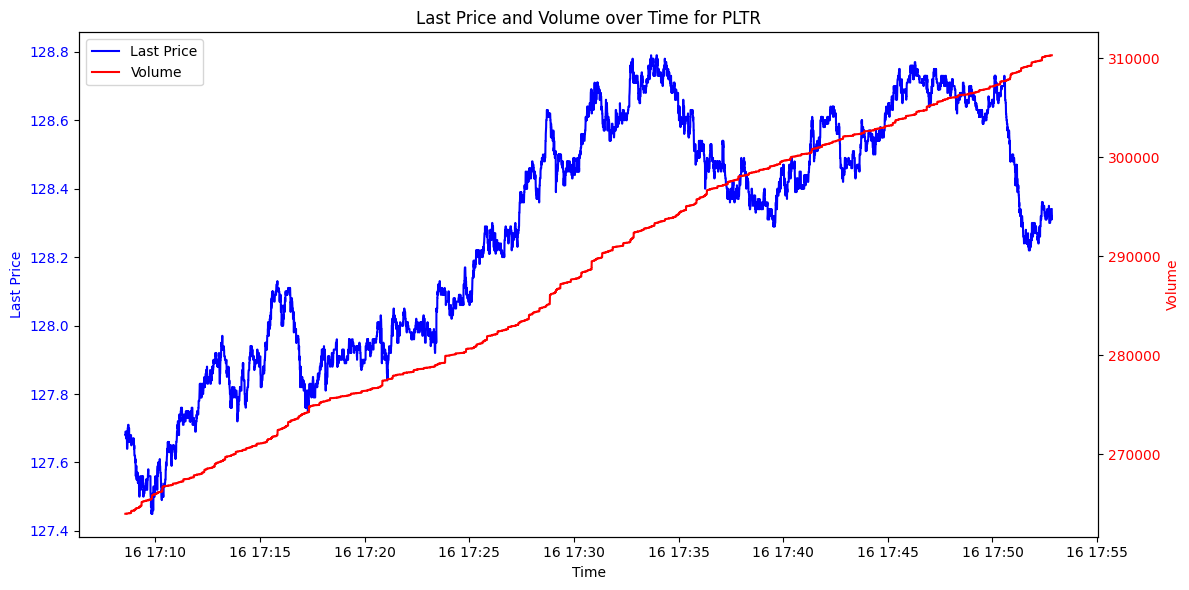

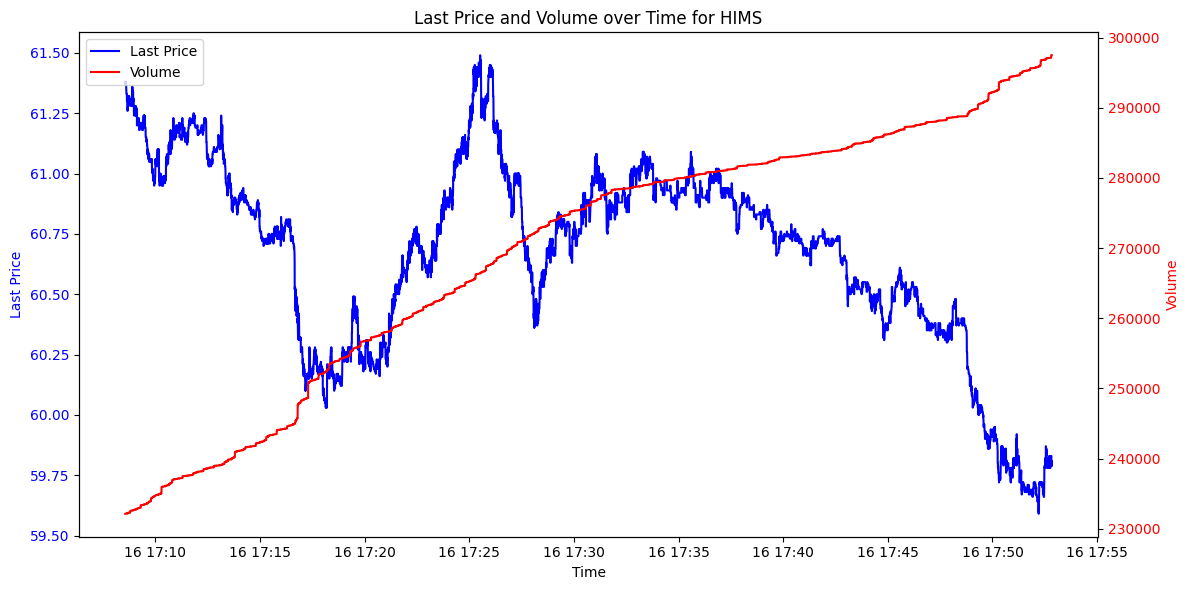

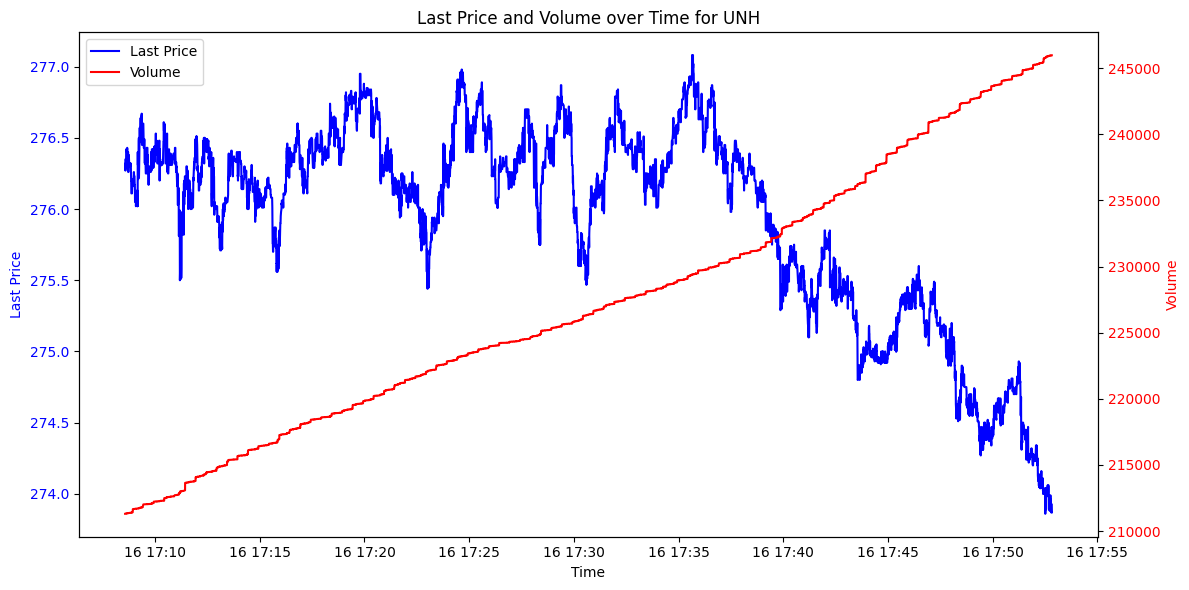

In [62]:
for sym in symbols:
    # Filter the data for the specific symbol
    df_sym = df_daily[df_daily['Symbol'] == sym]
    
    # Create a new figure and first axis for Last_price.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Last_price over time (using TS_Last_price).
    lns1 = ax1.plot(df_sym['TimeStamp'], df_sym['Last_price'], 
                    label='Last Price', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Last Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a twin Axes sharing the same x-axis for Volume.
    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_sym['TimeStamp'], df_sym['Volume'],
                    label='Volume', color='red')
    ax2.set_ylabel('Volume', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optionally, combine legends from both axes.
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')
    
    # Set a title and a bit of margin if desired.
    plt.title(f'Last Price and Volume over Time for {sym}')
    plt.tight_layout()
    plt.show()


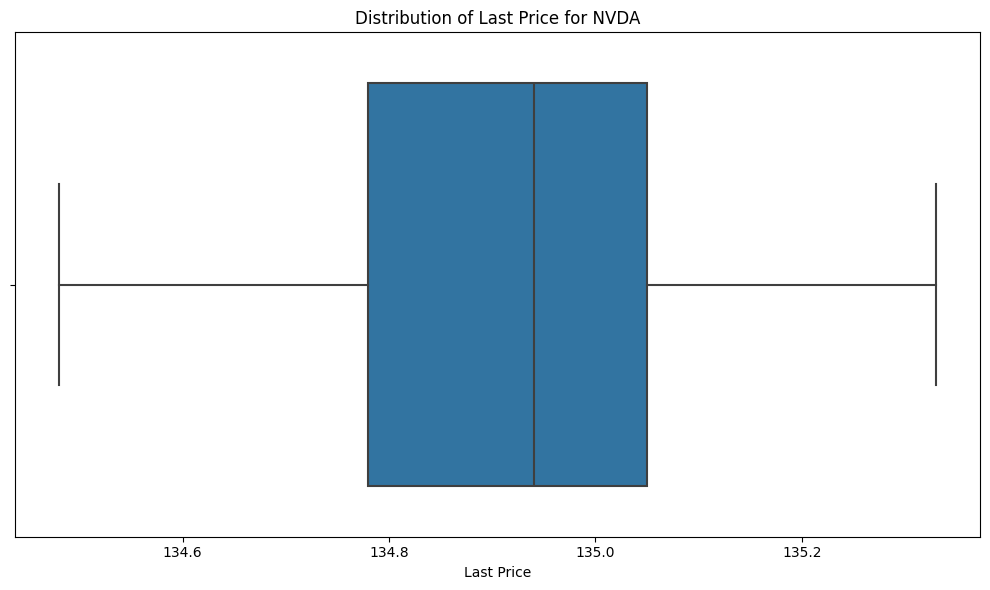

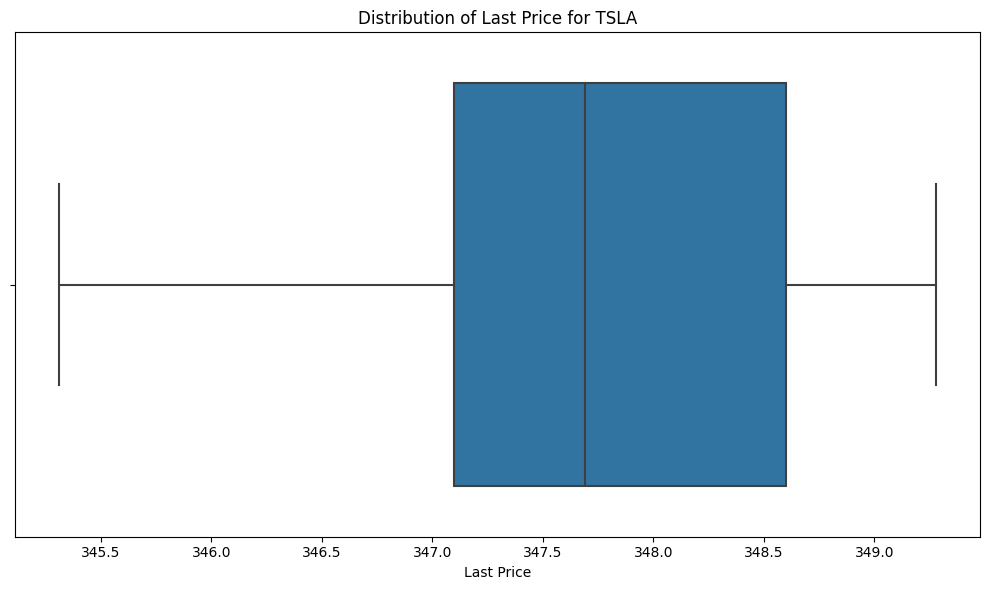

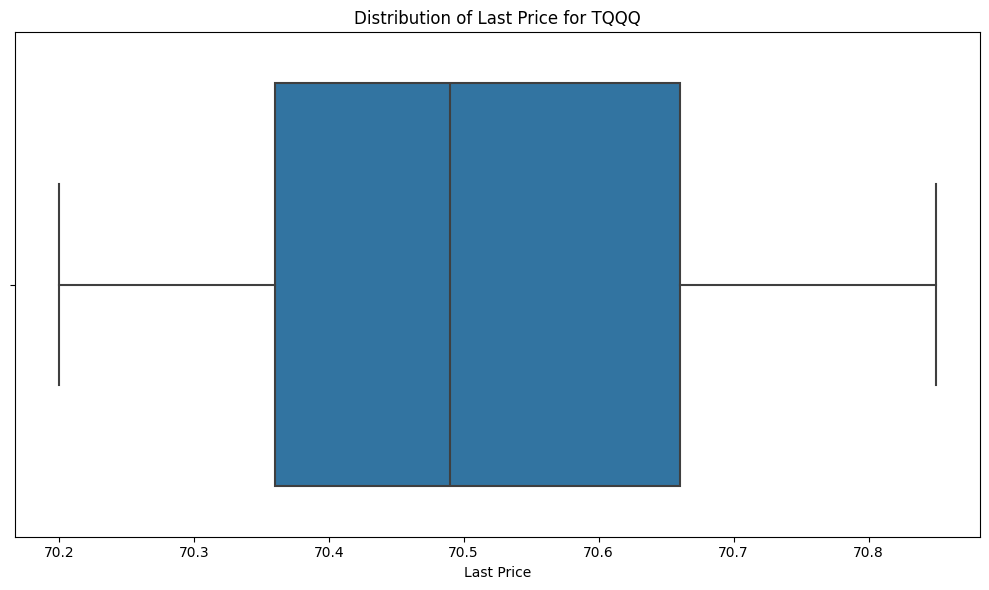

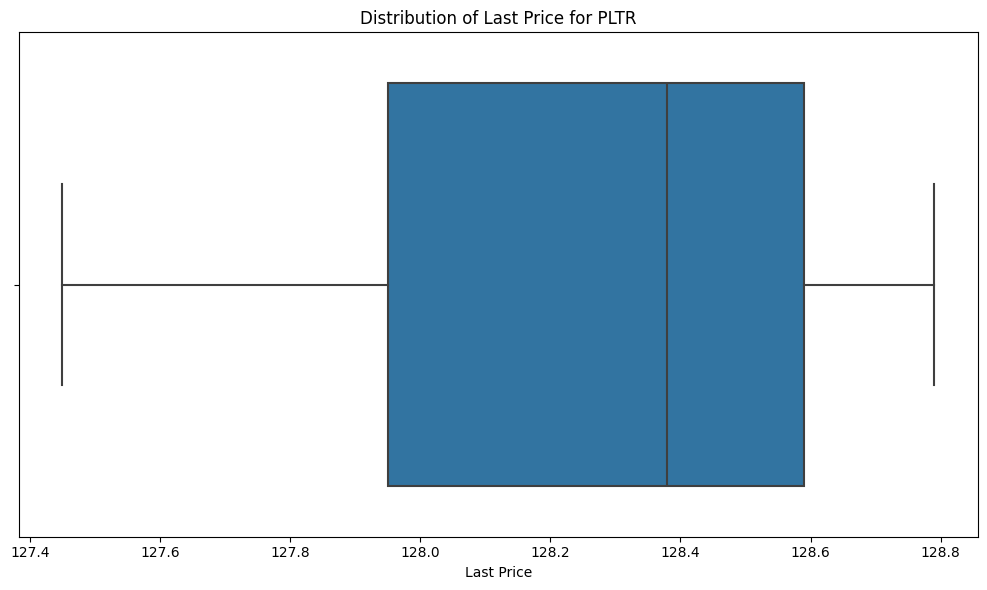

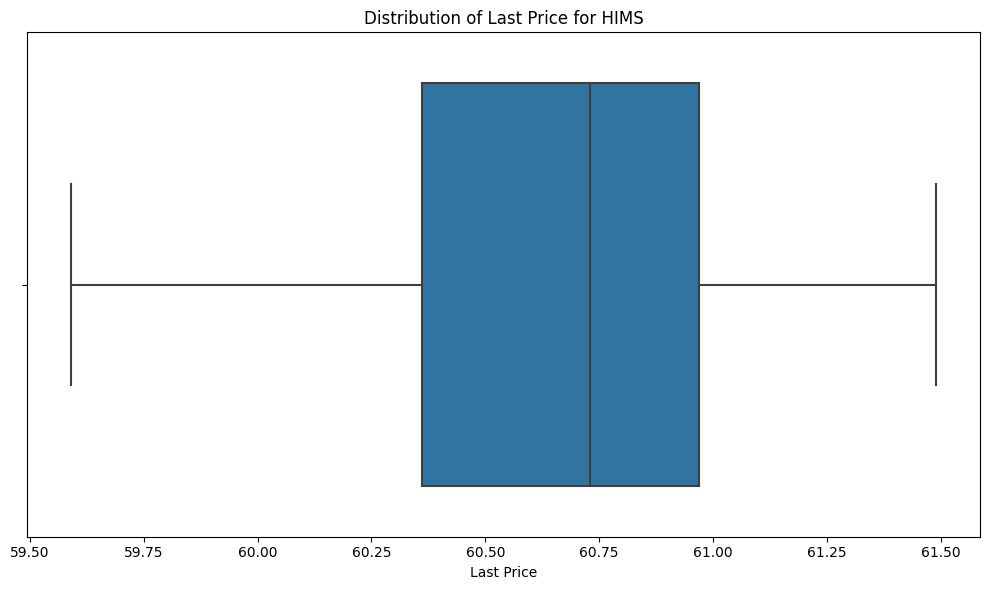

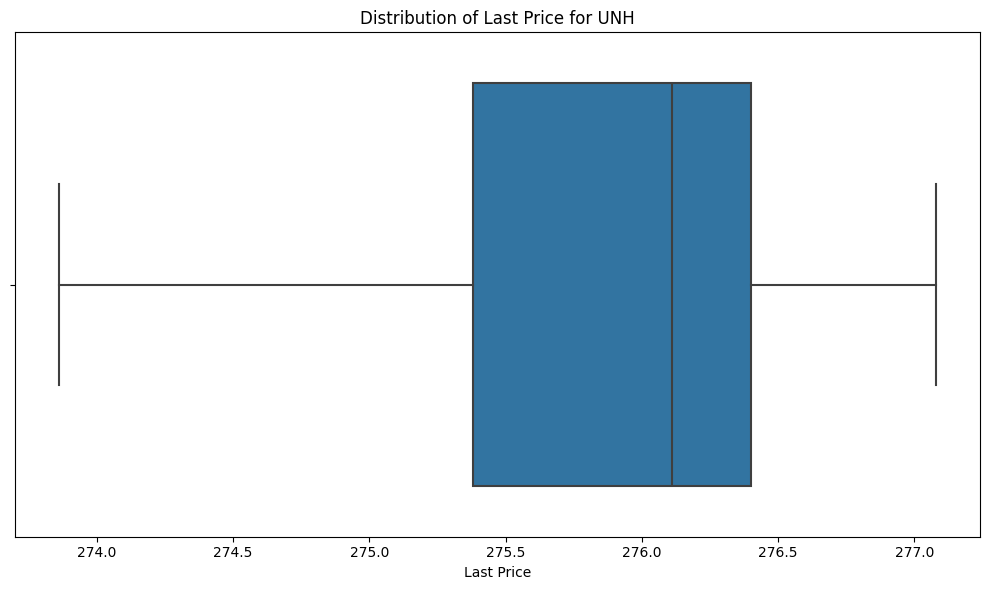

In [63]:
# Loop over each symbol
for sym in symbols:
    # Filter data for the specific symbol
    df_sym = df_daily[df_daily['Symbol'] == sym]
    
    # Create a new figure for the boxplot
    plt.figure(figsize=(10,6))
    
    # # Option 1: Using a single-variable boxplot
    sns.boxplot(x=df_sym['Last_price'])
    plt.xlabel('Last Price')
    
    # Option 2 (if you prefer to show the symbol category):  
    # sns.boxplot(x='Symbol', y='Last_price', data=df_sym)
    # This will display the symbol on the x-axis (though there is only one category).
    
    plt.title(f'Distribution of Last Price for {sym}')
    plt.tight_layout()
    plt.show()


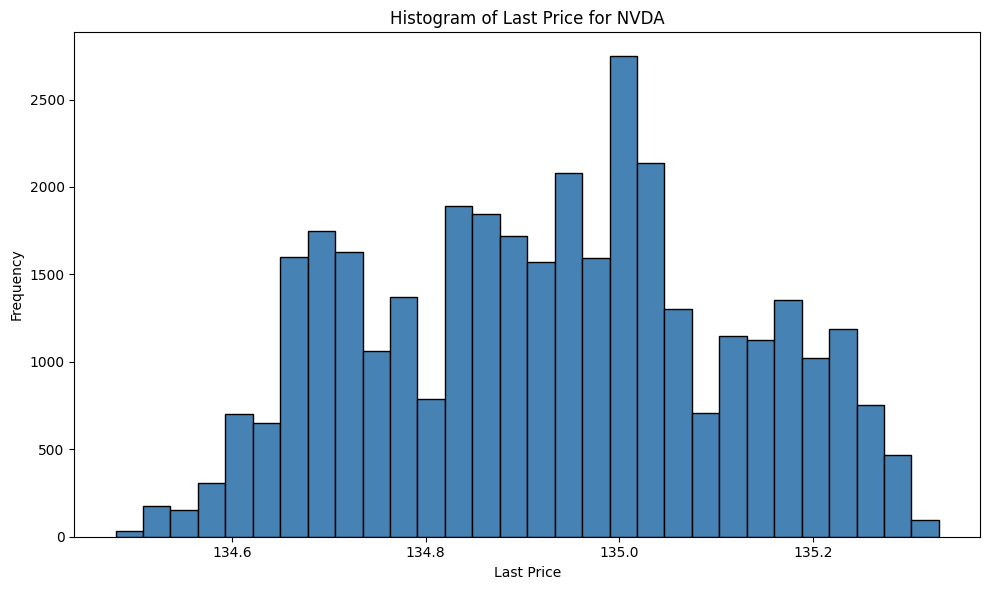

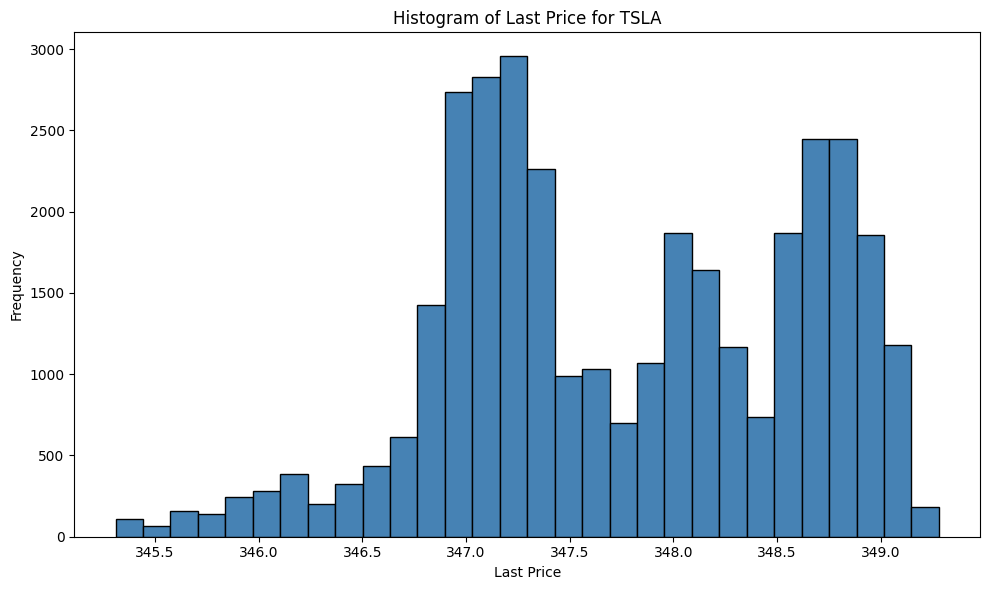

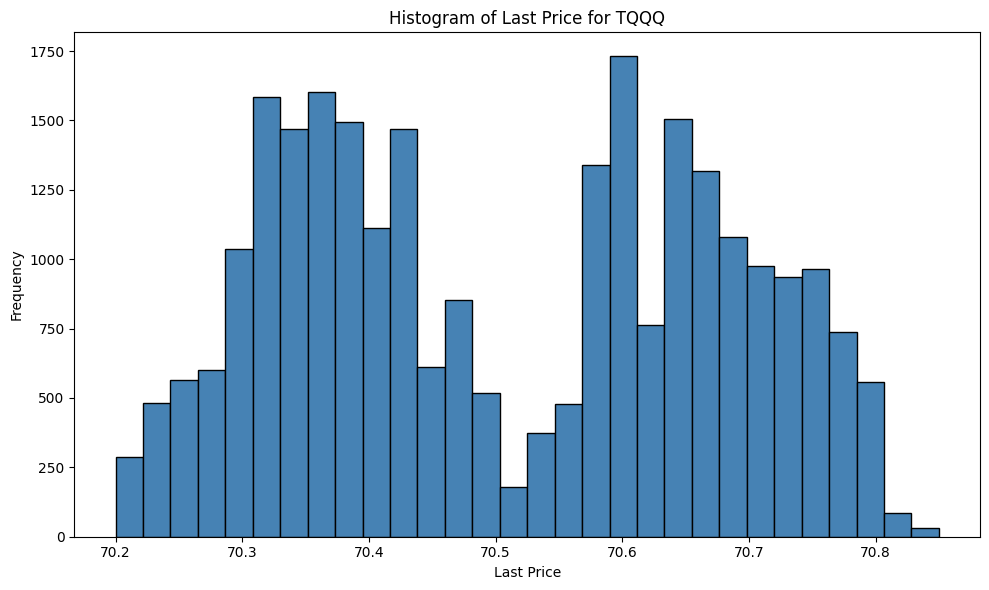

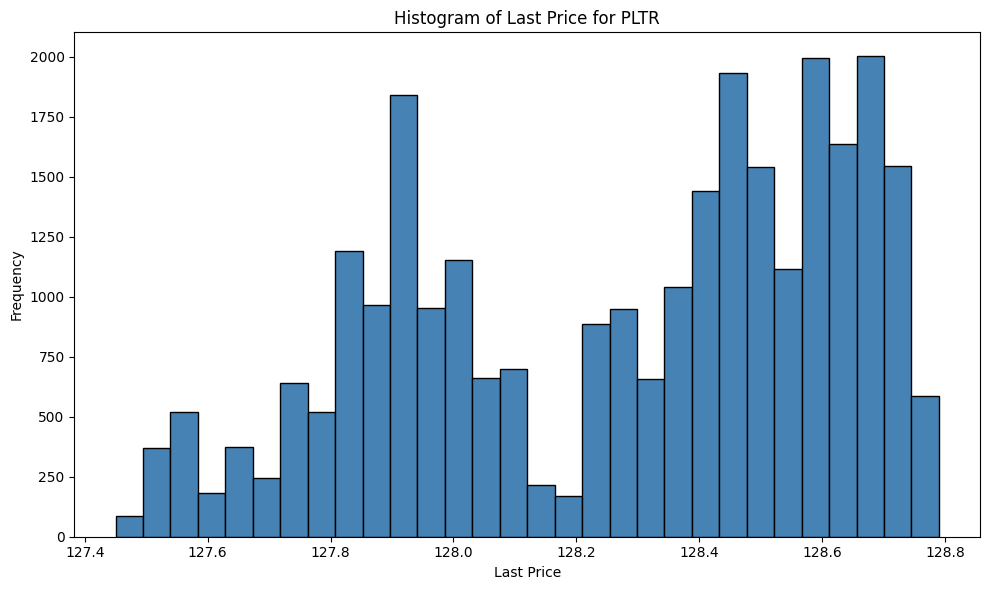

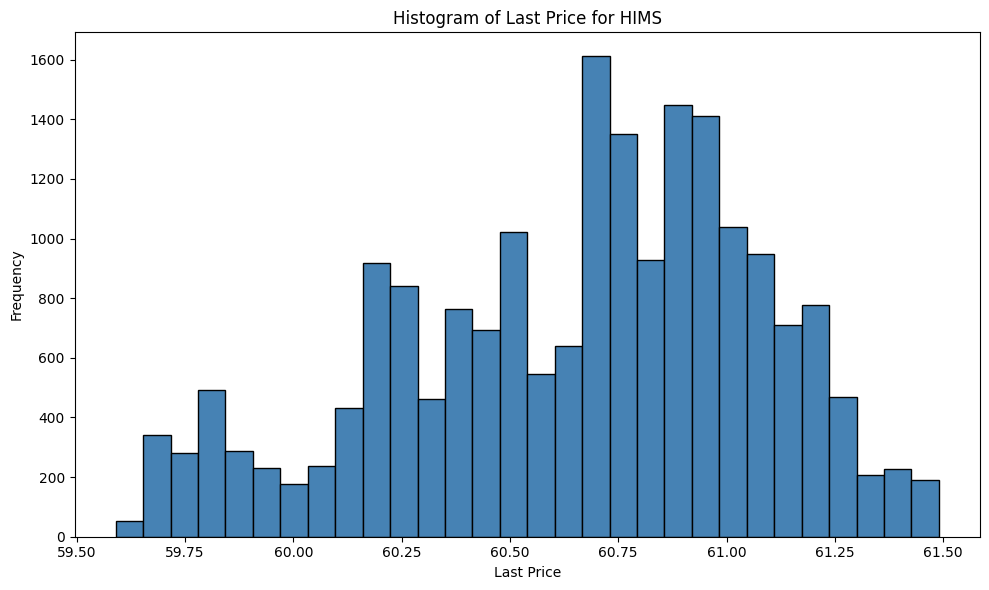

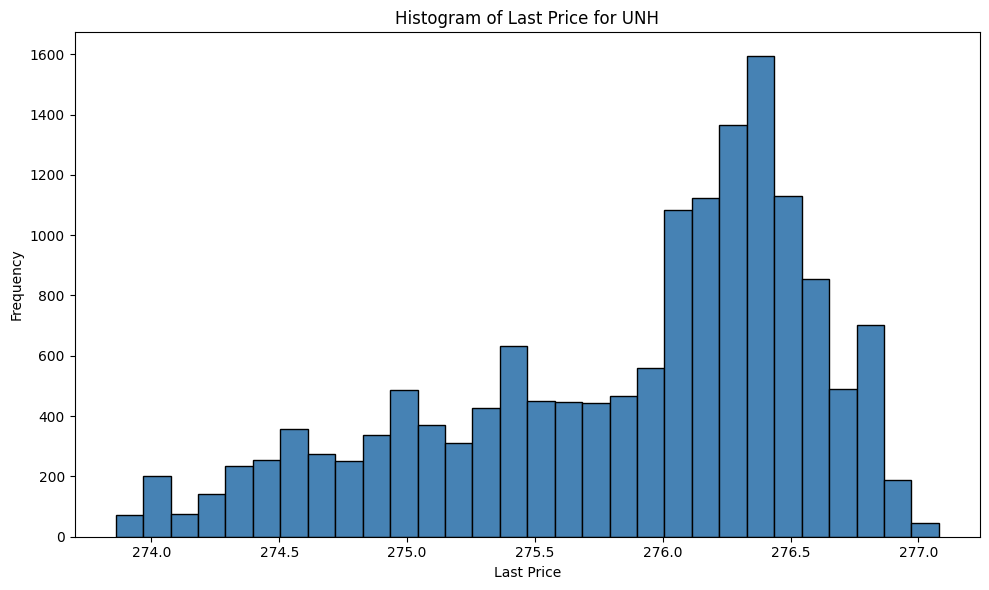

In [64]:
# Loop over each symbol and create an individual histogram.
for sym in symbols:
    df_sym = df_daily[df_daily['Symbol'] == sym]
    plt.figure(figsize=(10, 6))
    
    # Option 1: Using Matplotlib's plt.hist
    plt.hist(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
    # Option 2: Using Seaborn's histplot (uncomment if you prefer)
    # sns.histplot(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
    plt.xlabel('Last Price')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Last Price for {sym}')
    plt.tight_layout()
    plt.show()
